In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import imodelsx.process_results
import pickle as pkl
from collections import defaultdict
import viz
import sys
import notebook_helper
from matplotlib.backends.backend_pdf import PdfPages
sys.path.append('../experiments/')
# results_dir = '/home/chansingh/mntv1/tree-prompt/feb25'
# results_dir = '/home/chansingh/mntv1/tree-prompt/mar17'
results_dir = '/home/chansingh/mntv1/tree-prompt/mar18'

r = imodelsx.process_results.get_results_df(results_dir)
experiment_filename = '../experiments/01_fit.py'
r = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename)
r['mean_llm_calls'] = notebook_helper.add_mean_llm_calls(r)

r.to_pickle('../results/tprompt_results.pkl')
# r = pd.read_pickle('../results/tprompt_results.pkl')
ravg = r[r.seed == 1]

100%|██████████| 1081/1081 [01:39<00:00, 10.83it/s]


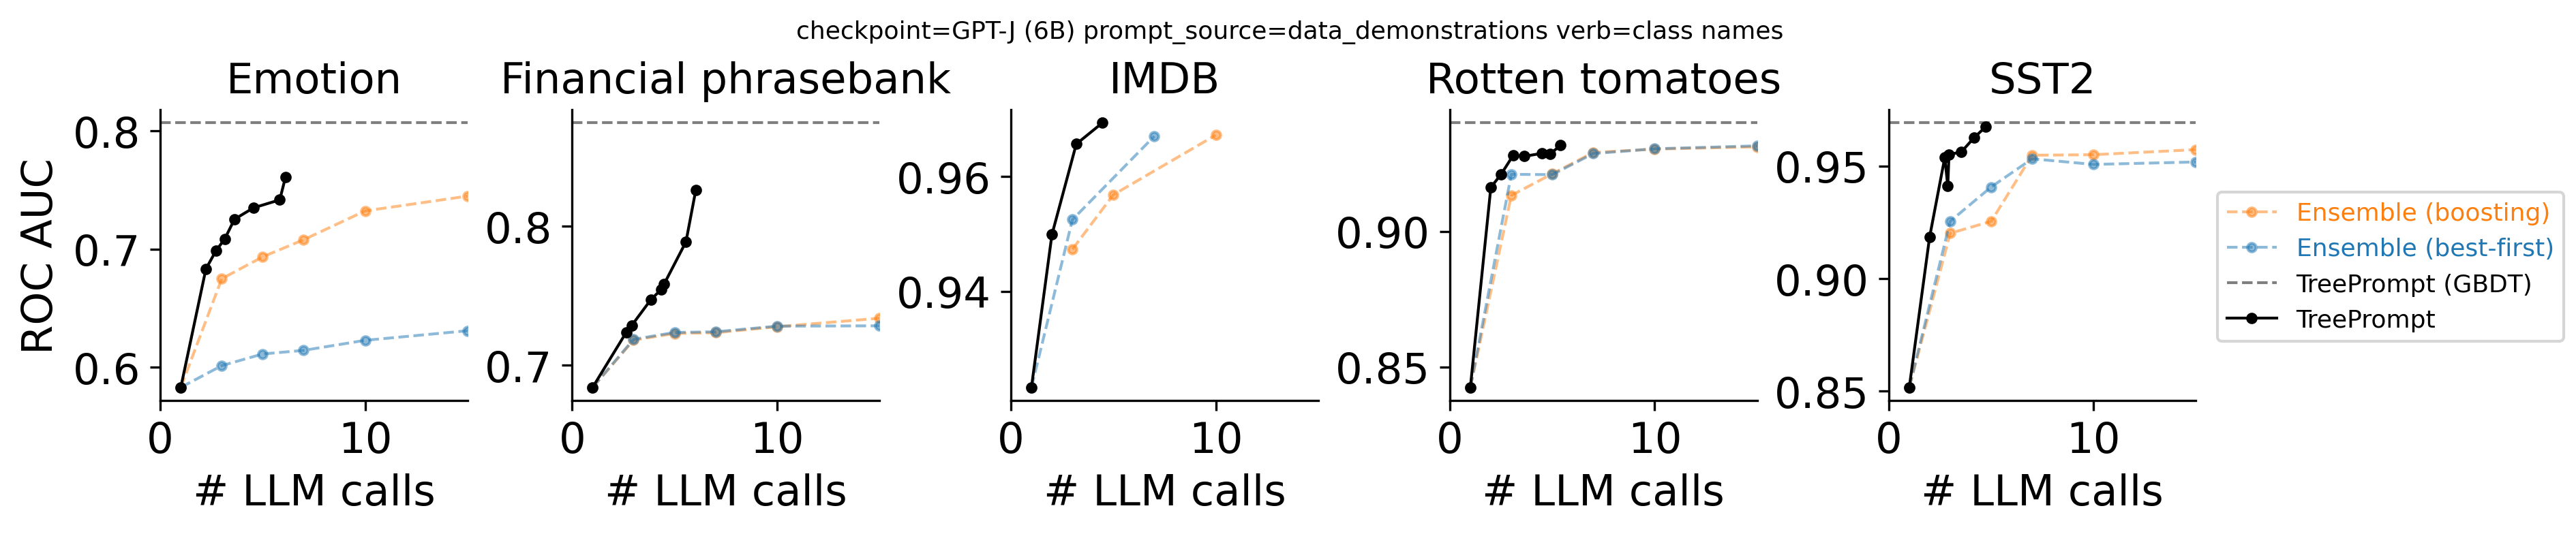

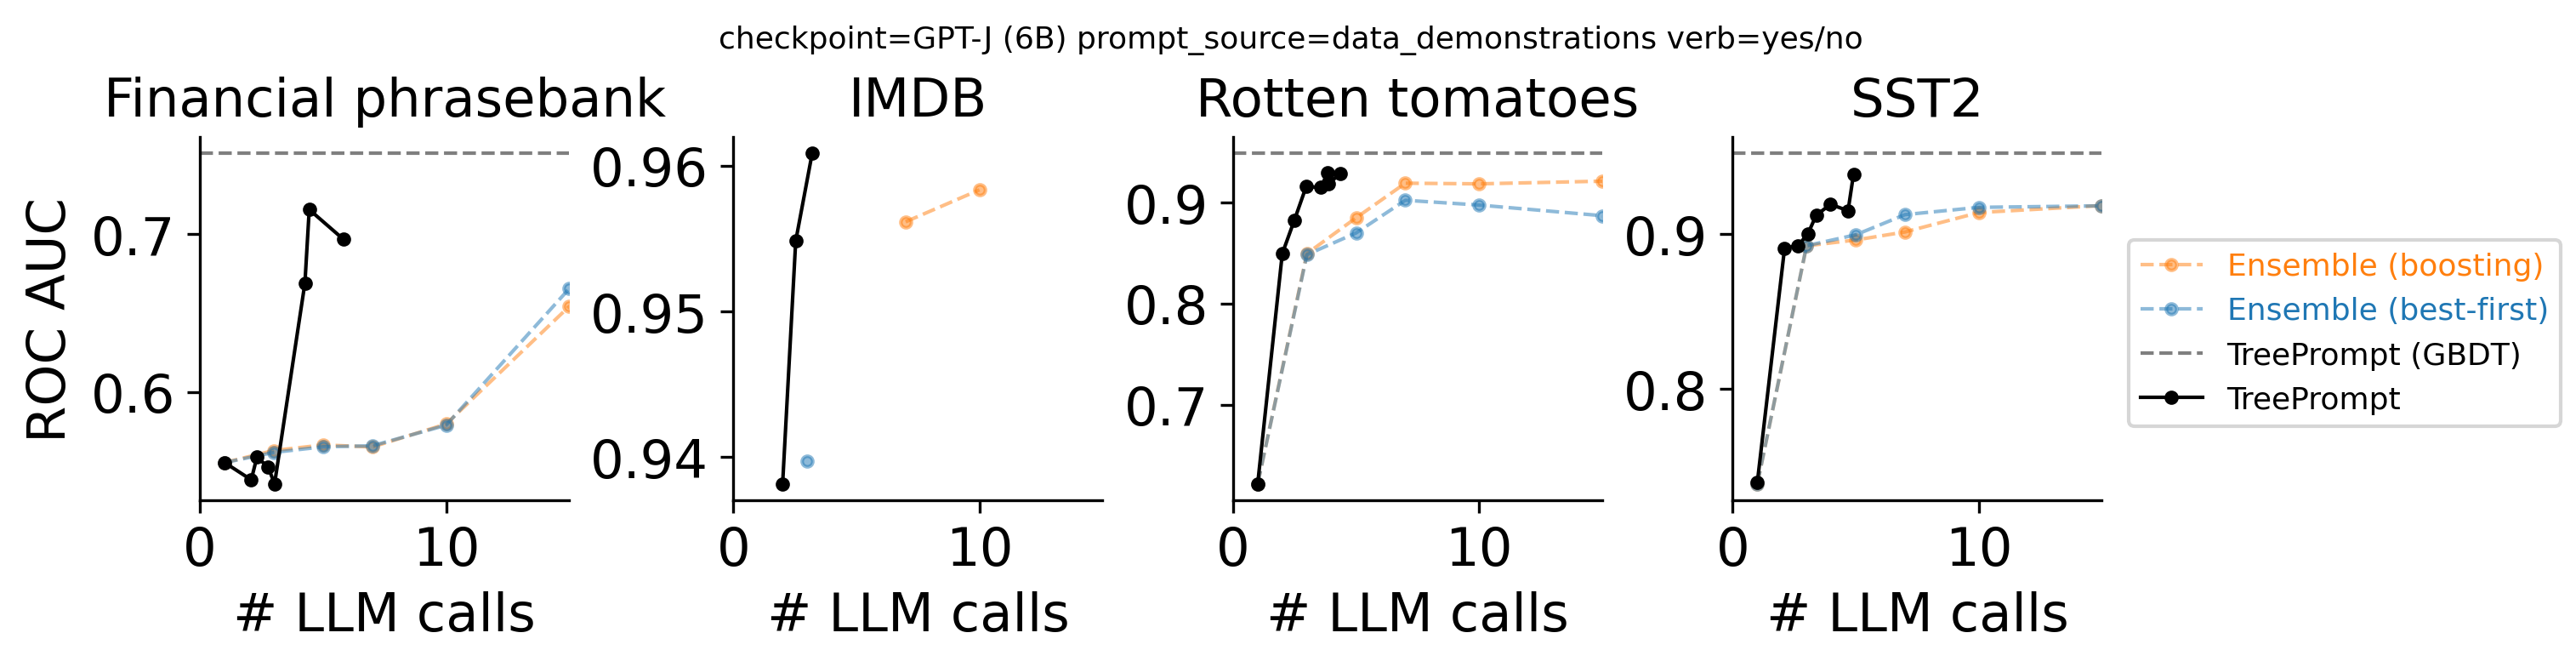

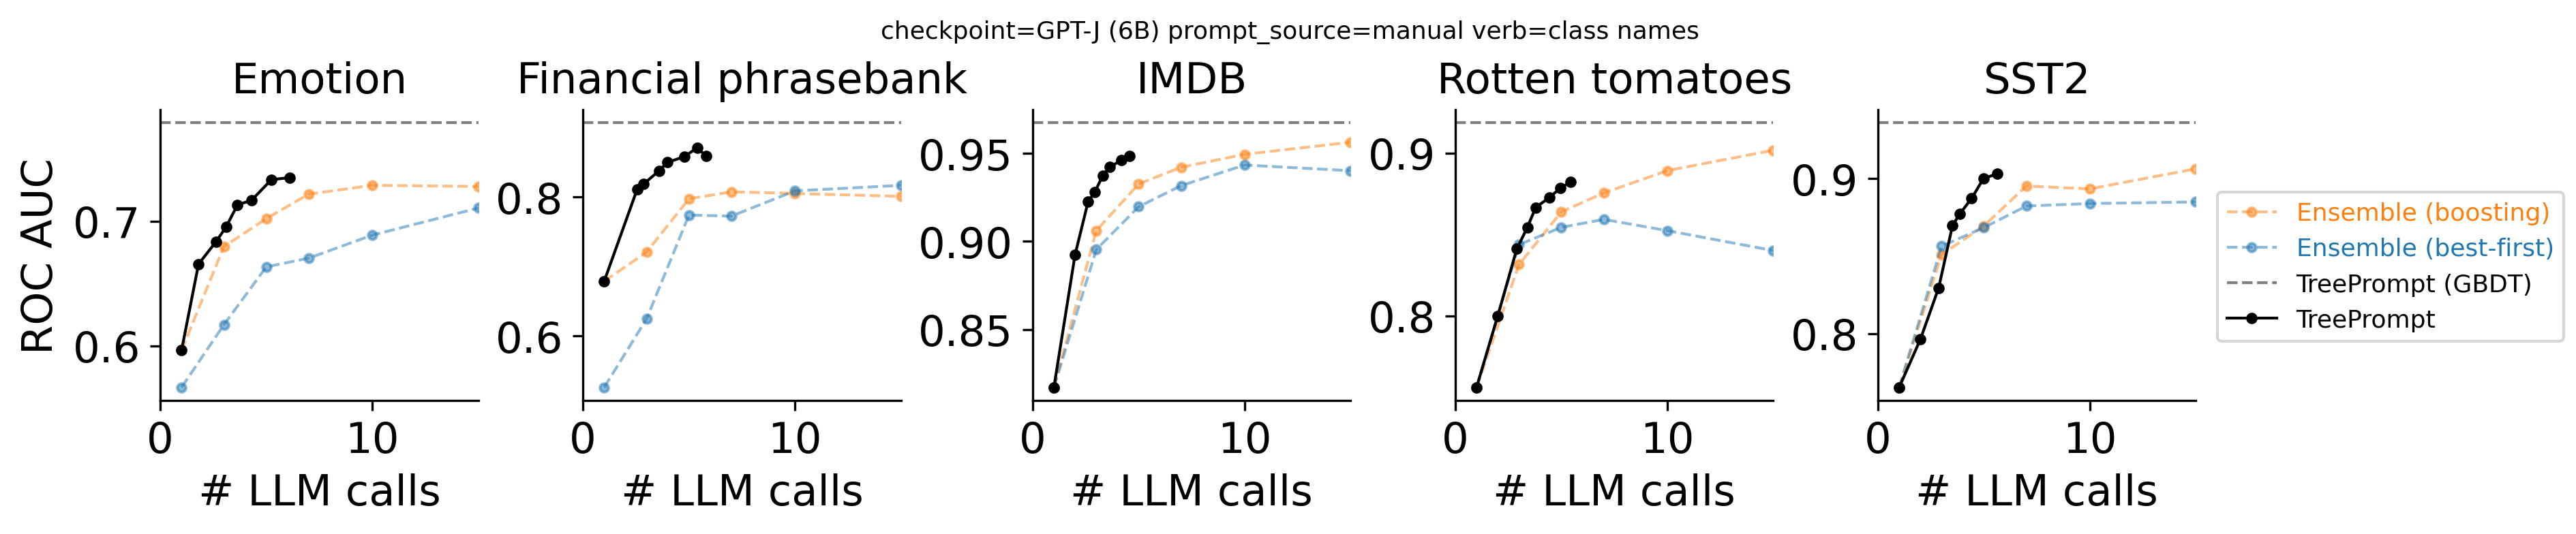

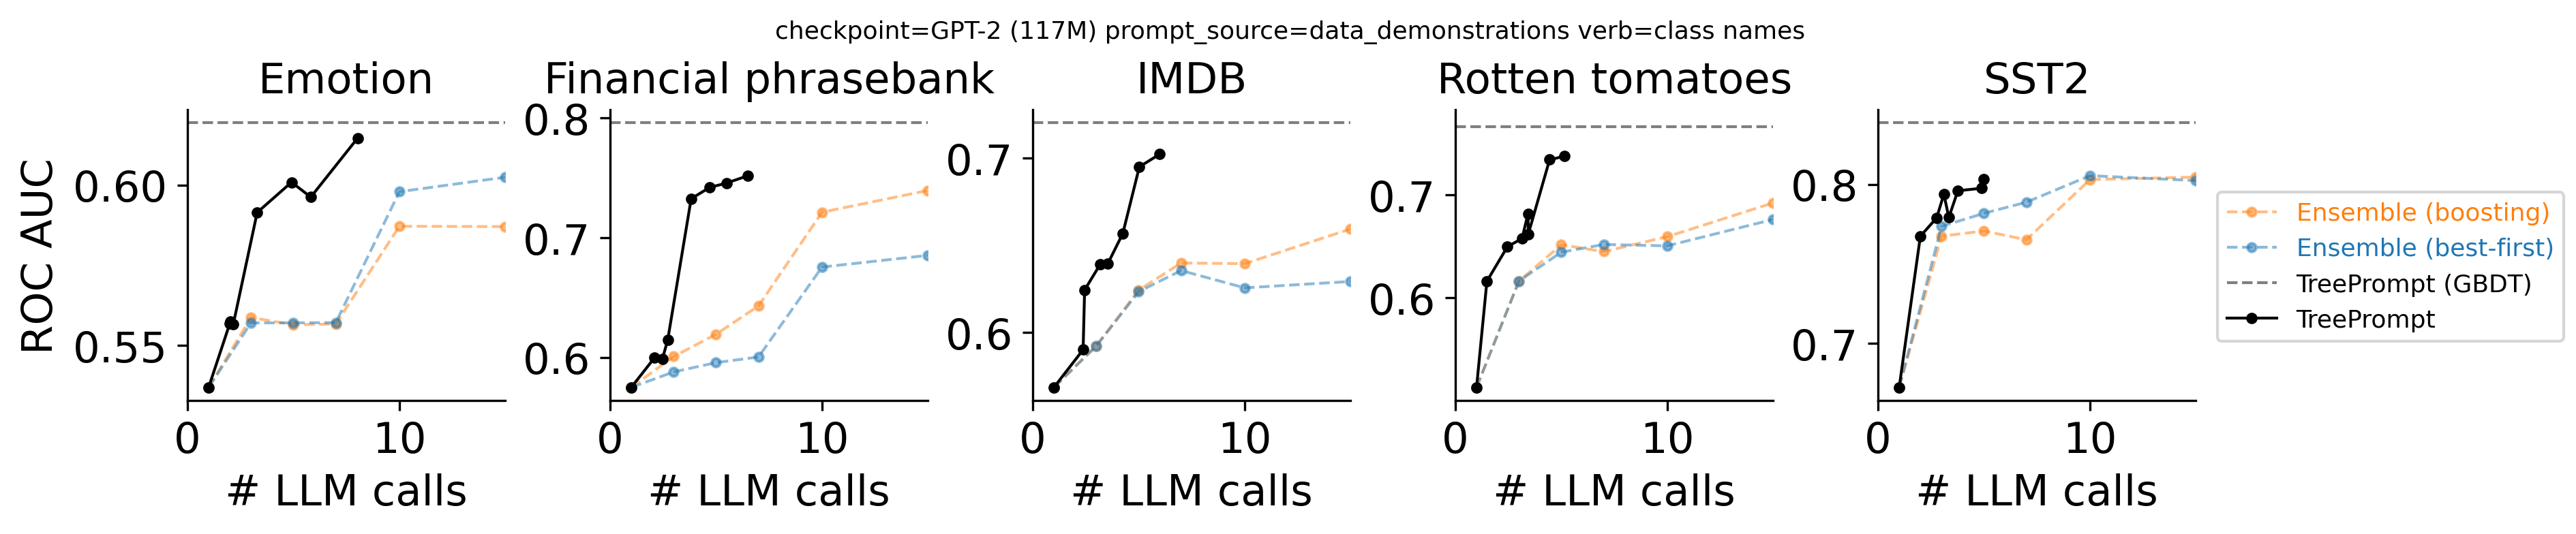

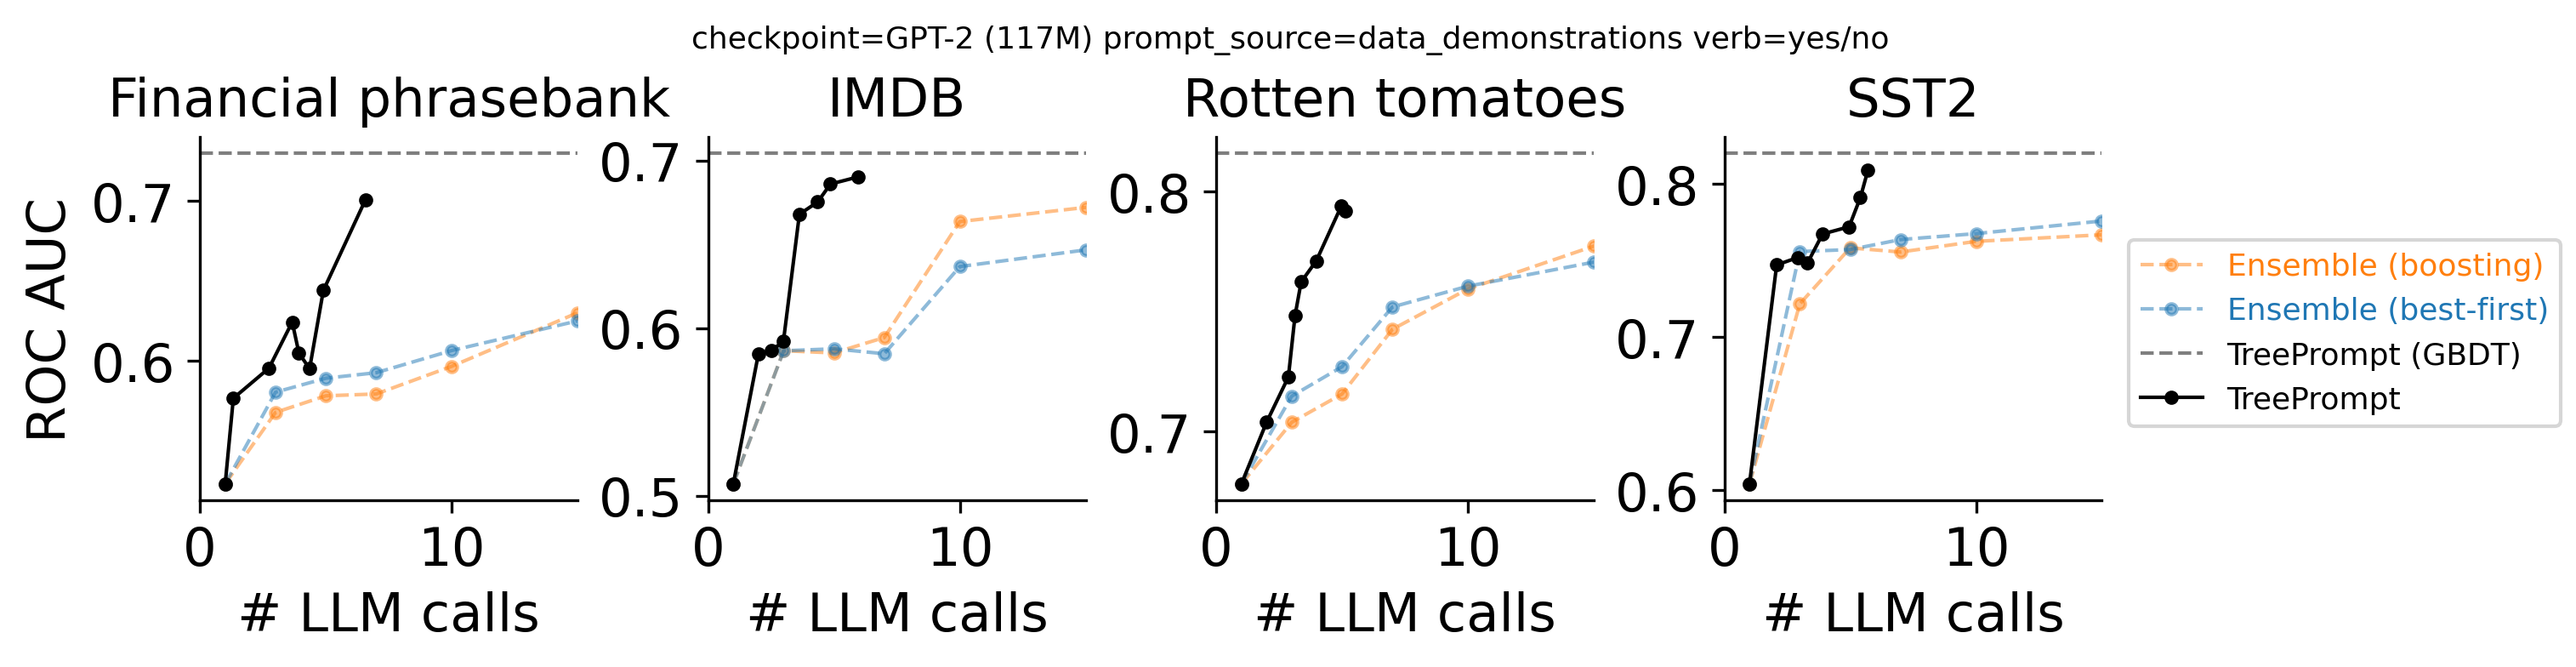

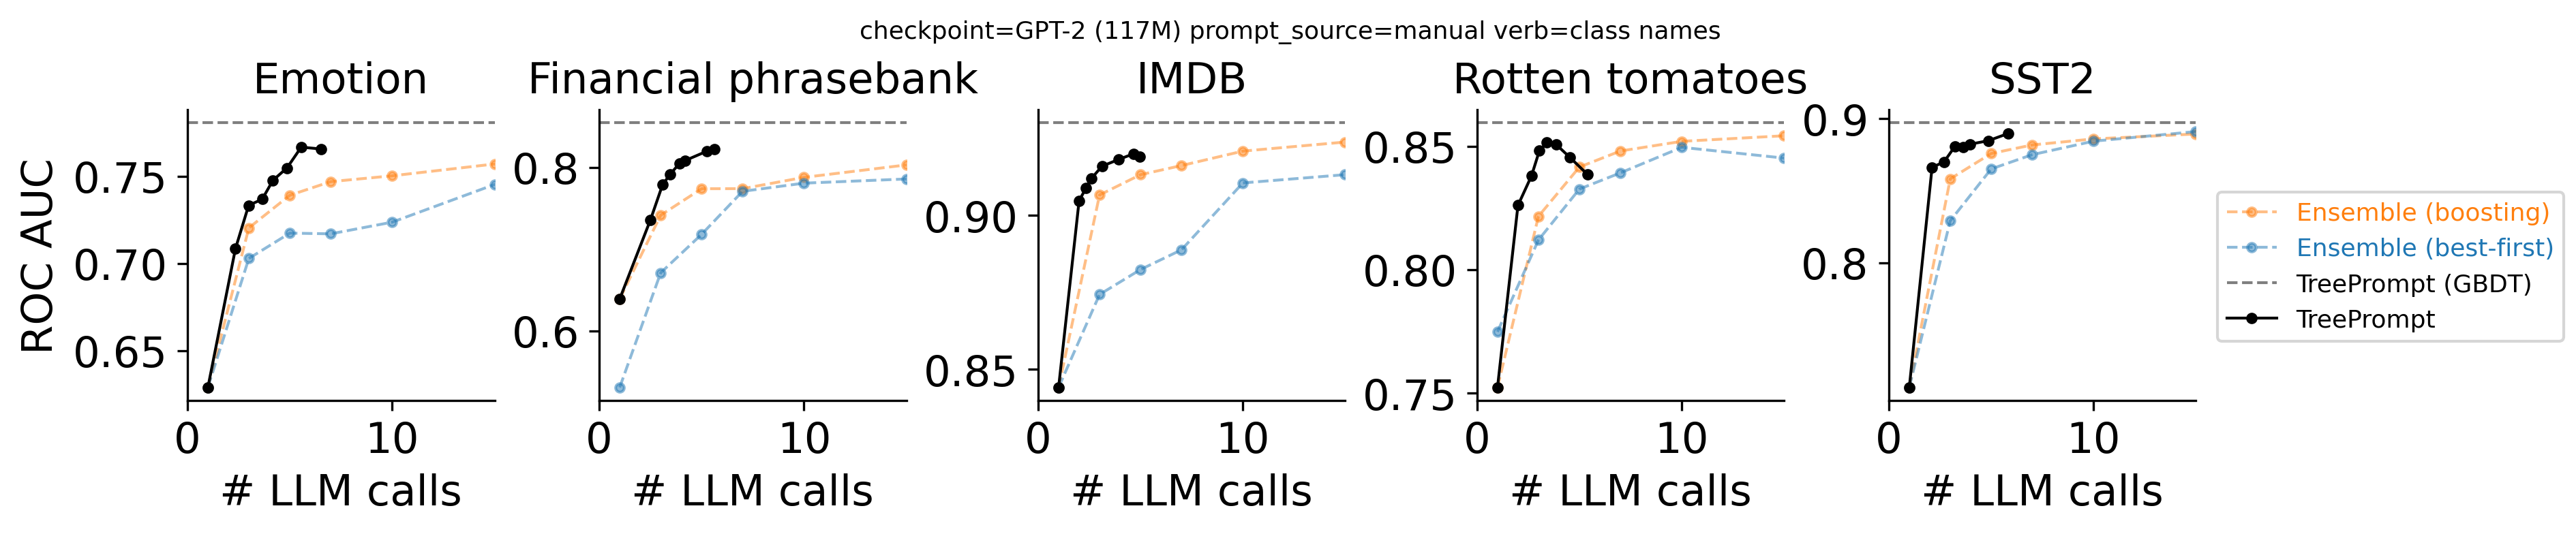

In [2]:
groupings = ['checkpoint', 'prompt_source', 'verbalizer_num'] #, 'binary_classification']
for k, rcurve in ravg.groupby(groupings):
    rcurve = rcurve.sort_values(by=['dataset_name', 'model_name', 'mean_llm_calls'])

    metric = 'roc_auc_test'
    # metric = 'accuracy'
    x = 'mean_llm_calls'                # x = 'num_prompts'

    viz.plot_perf_curves_individual(rcurve, x=x, xlim=15, metric=metric)
    x = rcurve.iloc[0]
    plt.suptitle(f'''checkpoint={viz.CHECKPOINTS_RENAME_DICT[x.checkpoint]} prompt_source={x.prompt_source} verb={viz.VERBS_RENAME_DICT[x.verbalizer_num]}''', fontsize='xx-small')
    # plt.tight_layout()
    # plt.show()

    # save a couple
    row = rcurve.iloc[0]
    if row.checkpoint == 'EleutherAI/gpt-j-6B' and row.prompt_source == 'data_demonstrations' and row.verbalizer_num == 0:
        plt.savefig('../results/figs/perf_curves_gptj.pdf', bbox_inches='tight')
    if row.checkpoint == 'gpt2' and row.prompt_source == 'manual' and row.verbalizer_num == 0:
        plt.savefig('../results/figs/perf_curves_gpt2.pdf', bbox_inches='tight')

viz.save_figs_to_single_pdf("all_results.pdf")

### Apply cross-validation

In [ ]:
# apply cross validation
ravg_cv = (
    ravg
    .sort_values(by='accuracy_cv', ascending=False)
    .groupby(by=['split_strategy', 'dataset_name'])
    .first()
    .reset_index()
)
ravg_cv

# Select individual results

In [6]:
rd = ravg
groupings2 = ['checkpoint', 'prompt_source', 'verbalizer_num', 'dataset_name', 'model_name']

dset_names = rd.dataset_name.unique().tolist()
mets = defaultdict(list)
for k, rcurve in rd.groupby(groupings2):    
    # rcurve = rcurve.sort_values(by='accuracy_cv', ascending=False)
    # metadata
    for kk in groupings2:
        mets[kk].append(rcurve.iloc[0][kk])
    mets['roc_auc<=5'].append(rcurve[rcurve['mean_llm_calls'] <= 5]['roc_auc_test'].max())

df = pd.DataFrame.from_dict(mets)
df['dataset_name'] = df['dataset_name'].apply(viz.DSETS_RENAME_DICT_ABBR.get)
df['model_name'] = df['model_name'].apply(viz.MODELS_RENAME_DICT.get)
df['checkpoint'] = df['checkpoint'].apply(viz.CHECKPOINTS_RENAME_DICT.get)
# df['prompt_source'] = df['prompt_source'].apply(viz.PROMPT_SOURCES_RENAME_DICT.get)
# print(df.style.hide().to_latex())
dfp = df.pivot_table(index=['checkpoint', 'prompt_source', 'verbalizer_num'], columns=['model_name', 'dataset_name'], values='roc_auc<=5').round(2)
print(dfp.to_latex().replace('NaN', '----'))

\begin{tabular}{lllrrrrrrrrrrrrrrr}
\toprule
           &        & model\_name & \multicolumn{5}{l}{Ensemble (best-first)} & \multicolumn{5}{l}{Ensemble (boosting)} & \multicolumn{5}{l}{TreePrompt} \\
           &        & dataset\_name &               Emotion &   FPB &  IMDB &    RT &  SST2 &             Emotion &   FPB &  IMDB &    RT &  SST2 &    Emotion &   FPB &  IMDB &    RT &  SST2 \\
checkpoint & prompt\_source & verbalizer\_num &                       &       &       &       &       &                     &       &       &       &       &            &       &       &       &       \\
\midrule
GPT-2 (117M) & data\_demonstrations & 0 &                  0.56 &  0.60 &  0.62 &  0.64 &  0.78 &                0.56 &  0.62 &  0.62 &  0.65 &  0.77 &       0.60 &  0.74 &  0.66 &  0.73 &  0.80 \\
           &        & 1 &                   ---- &  0.59 &  0.59 &  0.73 &  0.76 &                 ---- &  0.58 &  0.59 &  0.72 &  0.76 &        ---- &  0.64 &  0.69 &  0.79 &  0.77 \\
         

/tmp/ipykernel_1186469/259043592.py:20: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dfp.to_latex().replace('NaN', '----'))
